In [ ]:
from types import SimpleNamespace

In [1]:
pip install fastprogress

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import sys
sys.path.append('/home/user/.local/lib/python3.8/site-packages')
from fastprogress import progress_bar


In [ ]:
pip install wandb

In [2]:
import wandb, torch

In [3]:
pip install fastdownload

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Helper functions

In [4]:
from helpers import one_batch, plot_images, save_images

## Architecture of the model

### EMA (Exponential Moving Average) model

In [5]:
from ema import EMA, one_param

### Creating Unet_conditional model

In [6]:
from Unet import SelfAttention, DoubleConv, Down, Up, UNet, UNet_conditional

### Setting training class

In [10]:
import argparse, logging, copy
from types import SimpleNamespace
from contextlib import nullcontext

import torch
from torch import optim
import torch.nn as nn
import numpy as np
from fastprogress import progress_bar

import wandb

import os
import urllib.request
import tarfile
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # Import tqdm for progress bar


from diffusion import Diffusion


config = SimpleNamespace(
    run_name = "DDPM_conditional",
    epochs = 100,
    noise_steps=1000,
    seed = 42,
    batch_size = 10,
    img_size = 64,
    num_classes = 10,
    train_folder = "train",
    val_folder = "test",
    device = "cuda",
    slice_size = 1,
    do_validation = True,
    fp16 = True,
    log_every_epoch = 10,
    num_workers=10,
    lr = 5e-3)


logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")





def parse_args(config):
    parser = argparse.ArgumentParser(description='Process hyper-parameters')
    parser.add_argument('--run_name', type=str, default=config.run_name, help='name of the run')
    parser.add_argument('--epochs', type=int, default=config.epochs, help='number of epochs')
    parser.add_argument('--seed', type=int, default=config.seed, help='random seed')
    parser.add_argument('--batch_size', type=int, default=config.batch_size, help='batch size')
    parser.add_argument('--img_size', type=int, default=config.img_size, help='image size')
    parser.add_argument('--num_classes', type=int, default=config.num_classes, help='number of classes')
    parser.add_argument('--device', type=str, default=config.device, help='device')
    parser.add_argument('--lr', type=float, default=config.lr, help='learning rate')
    parser.add_argument('--slice_size', type=int, default=config.slice_size, help='slice size')
    parser.add_argument('--noise_steps', type=int, default=config.noise_steps, help='noise steps')
    args = vars(parser.parse_args())

    # update config with parsed args
    for k, v in args.items():
        setattr(config, k, v)


if __name__ == '__main__':
    parse_args(config)

    ## seed everything
    diffuser = Diffusion(config.noise_steps, img_size=config.img_size, num_classes=config.num_classes)
    with wandb.init(project="train_sd", group="train", config=config):
        diffuser.prepare(config)
        diffuser.fit(config)

usage: ipykernel_launcher.py [-h] [--run_name RUN_NAME] [--epochs EPOCHS]
                             [--seed SEED] [--batch_size BATCH_SIZE]
                             [--img_size IMG_SIZE] [--num_classes NUM_CLASSES]
                             [--device DEVICE] [--lr LR]
                             [--slice_size SLICE_SIZE]
                             [--noise_steps NOISE_STEPS]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/user/.local/share/jupyter/runtime/kernel-368eeb1e-c57f-4bc6-a4de-82058d4b591b.json


SystemExit: 2

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Setting parameters for training model

In [11]:
import argparse
from pathlib import Path

class Config:
    def __init__(self):
        # Set default values for each attribute
        self.run_name = 'DDPM_conditional'
        self.epochs = 100
        self.noise_steps = 1000
        self.seed = 42
        self.batch_size = 128
        self.img_size = 64
        self.num_classes = 10

        self.device = 'cuda'
        self.slice_size = 1
        self.use_wandb = True
        self.do_validation = False
        self.log_every_epoch = 10
        self.num_workers = 10
        self.lr = 0.0003

    def parse_args(self):
        parser = argparse.ArgumentParser(description='Process hyper-parameters')

        parser.add_argument('--run_name', type=str, default=self.run_name, help='name of the run')
        parser.add_argument('--epochs', type=int, default=self.epochs, help='number of epochs')
        parser.add_argument('--noise_steps', type=int, default=self.noise_steps, help='noise steps')
        parser.add_argument('--seed', type=int, default=self.seed, help='random seed')
        parser.add_argument('--batch_size', type=int, default=self.batch_size, help='batch size')
        parser.add_argument('--img_size', type=int, default=self.img_size, help='image size')
        parser.add_argument('--num_classes', type=int, default=self.num_classes, help='number of classes')

        parser.add_argument('--device', type=str, default=self.device, help='device')
        parser.add_argument('--slice_size', type=int, default=self.slice_size, help='slice size')
        parser.add_argument('--use_wandb', type=bool, default=self.use_wandb, help='use Weights & Biases')
        parser.add_argument('--do_validation', type=bool, default=self.do_validation, help='perform validation')
        parser.add_argument('--log_every_epoch', type=int, default=self.log_every_epoch, help='logging interval')
        parser.add_argument('--num_workers', type=int, default=self.num_workers, help='number of workers')
        parser.add_argument('--lr', type=float, default=self.lr, help='learning rate')

        args, _ = parser.parse_known_args()

        for key, value in vars(args).items():
            setattr(self, key, value)

    def __repr__(self):
        return f"Config({', '.join([f'{k}={v}' for k, v in self.__dict__.items()])})"

# Example usage
config = Config()
config.parse_args()
print(config)

Config(run_name=DDPM_conditional, epochs=100, noise_steps=1000, seed=42, batch_size=128, img_size=64, num_classes=10, device=cuda, slice_size=1, use_wandb=True, do_validation=False, log_every_epoch=10, num_workers=10, lr=0.0003)


## Loading trained weights and training model:

wandb: Currently logged in as: abdurahmon_a (abdurahmon_a-innopolis-university). Use `wandb login --relogin` to force relogin


11:17:04 - INFO: Starting epoch 0:


/tmp/ipykernel_4081/130008081.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
11:18:37 - INFO: Sampling 10 new images....


11:19:59 - INFO: Sampling 10 new images....


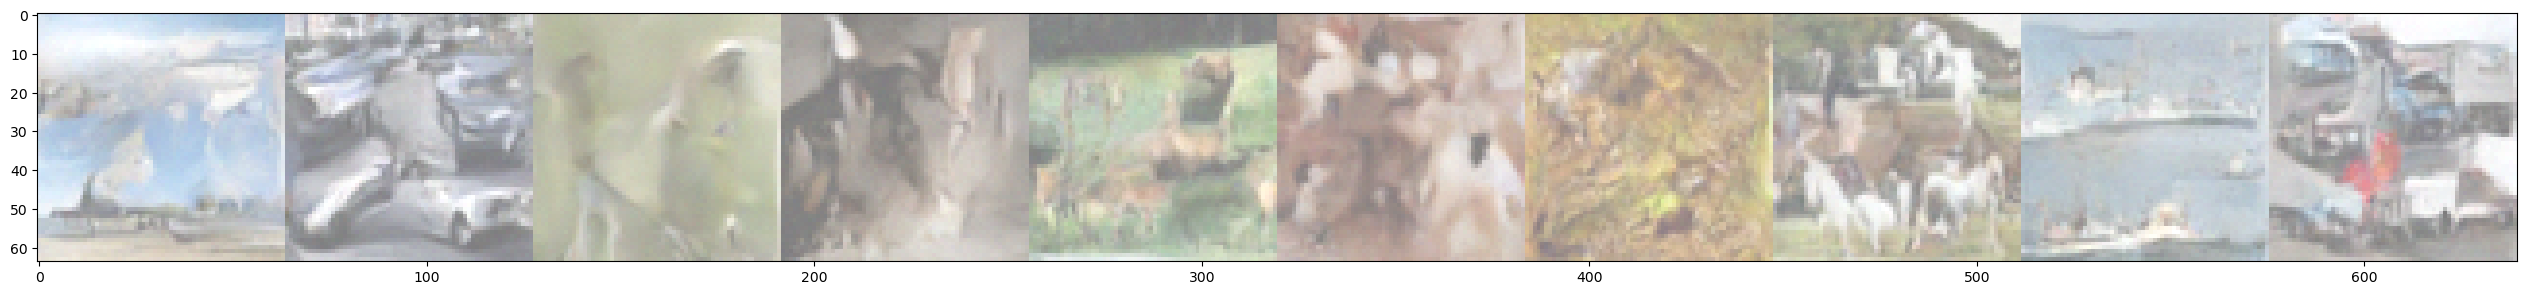

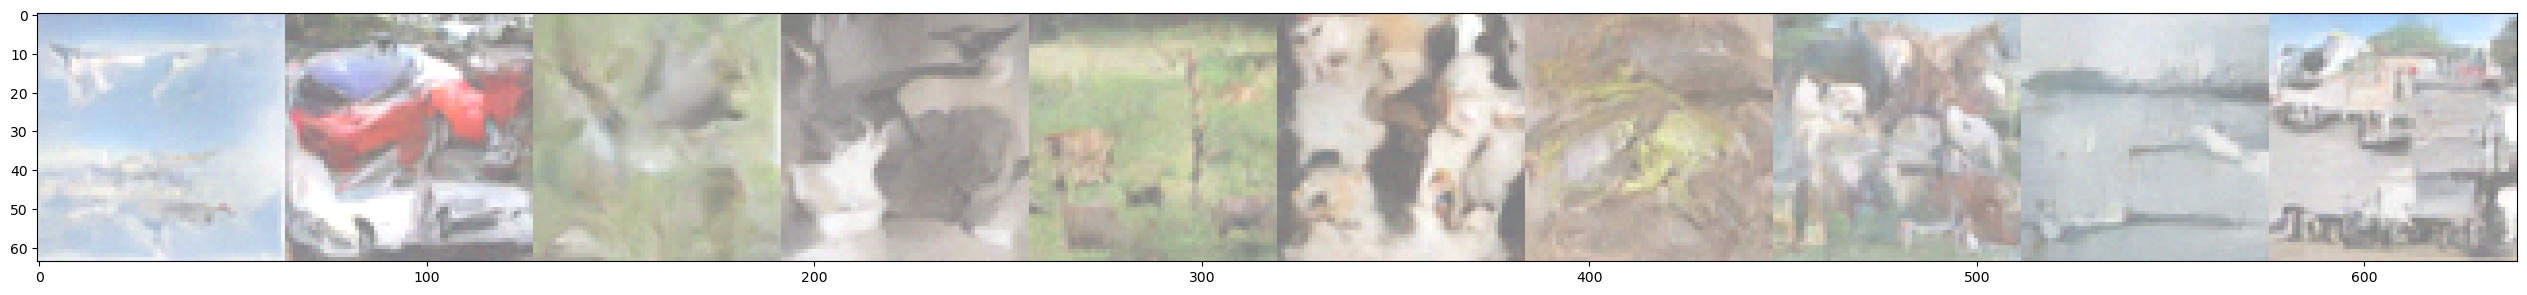

11:21:22 - INFO: Starting epoch 1:


11:22:55 - INFO: Starting epoch 2:


11:24:27 - INFO: Starting epoch 3:


11:26:00 - INFO: Starting epoch 4:


11:27:33 - INFO: Starting epoch 5:


11:29:06 - INFO: Starting epoch 6:


11:30:37 - INFO: Starting epoch 7:


11:32:10 - INFO: Starting epoch 8:


11:33:42 - INFO: Starting epoch 9:


11:35:14 - INFO: Starting epoch 10:


11:36:47 - INFO: Sampling 10 new images....


11:38:08 - INFO: Sampling 10 new images....


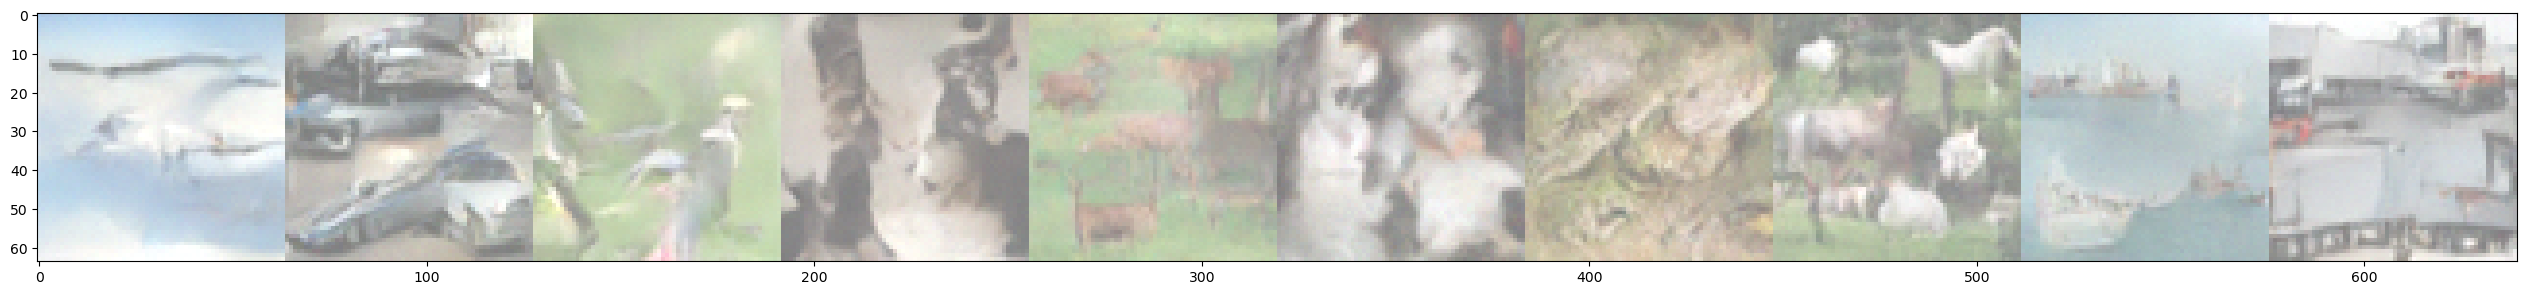

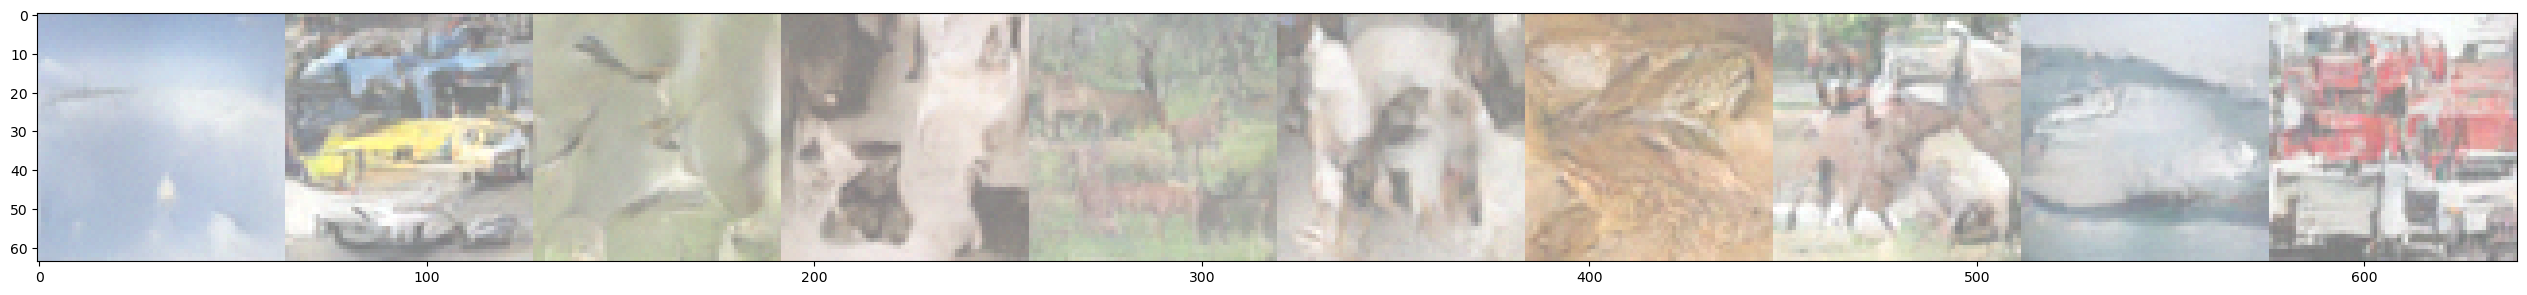

11:39:31 - INFO: Starting epoch 11:


11:41:03 - INFO: Starting epoch 12:


11:42:36 - INFO: Starting epoch 13:


11:44:08 - INFO: Starting epoch 14:


11:45:42 - INFO: Starting epoch 15:


11:47:11 - INFO: Starting epoch 16:


11:48:40 - INFO: Starting epoch 17:


11:50:08 - INFO: Starting epoch 18:


11:51:35 - INFO: Starting epoch 19:


11:53:03 - INFO: Starting epoch 20:


11:54:31 - INFO: Sampling 10 new images....


11:55:52 - INFO: Sampling 10 new images....


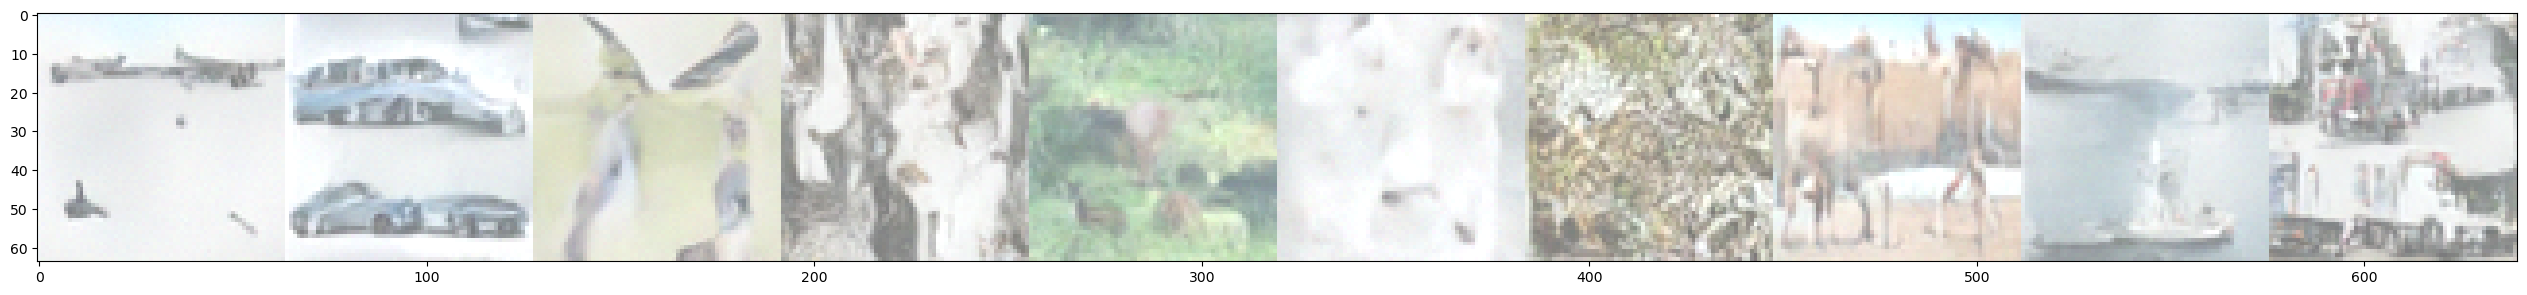

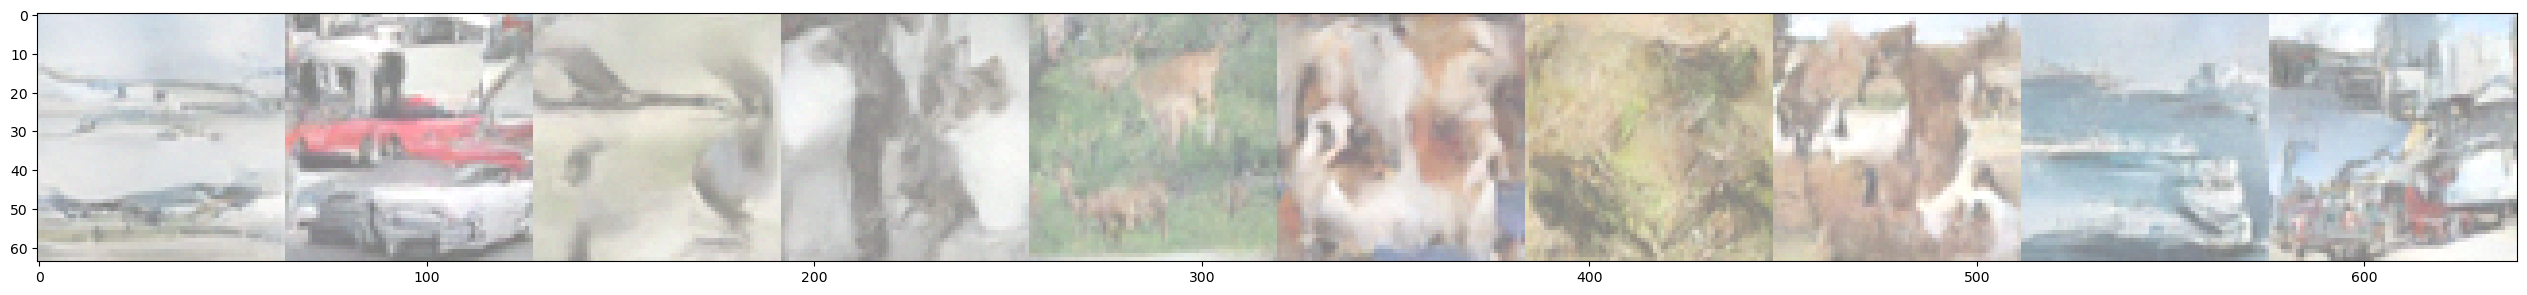

11:57:14 - INFO: Starting epoch 21:


11:58:42 - INFO: Starting epoch 22:


12:00:09 - INFO: Starting epoch 23:


12:01:37 - INFO: Starting epoch 24:


12:03:05 - INFO: Starting epoch 25:


12:04:33 - INFO: Starting epoch 26:


12:06:01 - INFO: Starting epoch 27:


12:07:29 - INFO: Starting epoch 28:


12:08:57 - INFO: Starting epoch 29:


12:10:25 - INFO: Starting epoch 30:


12:11:53 - INFO: Sampling 10 new images....


12:13:14 - INFO: Sampling 10 new images....


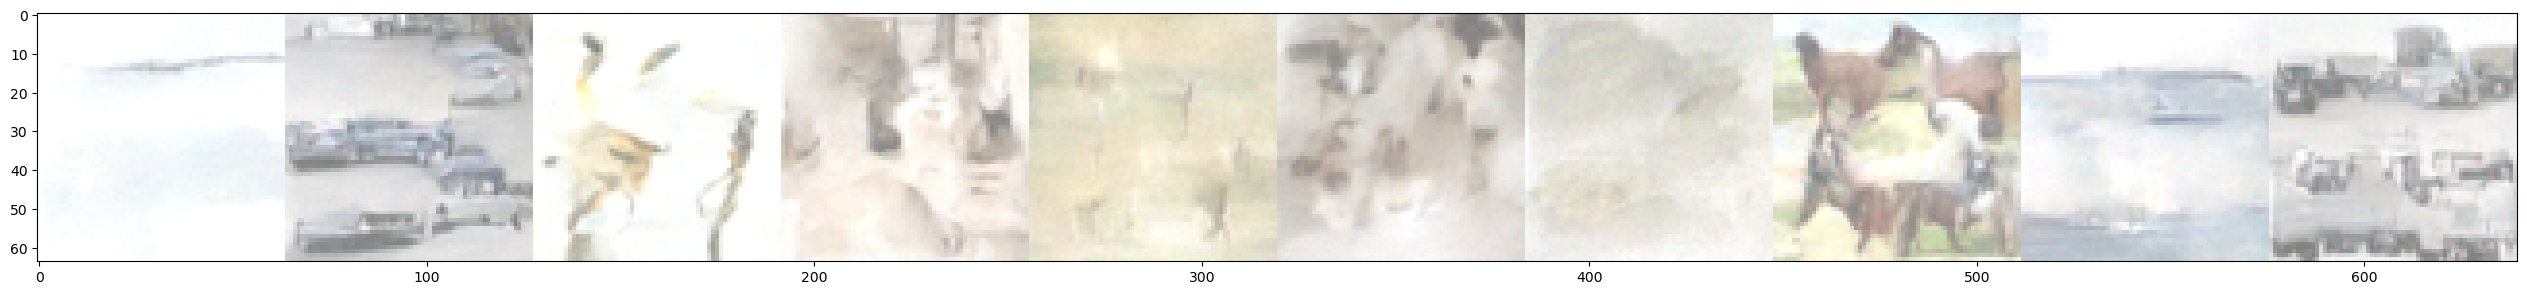

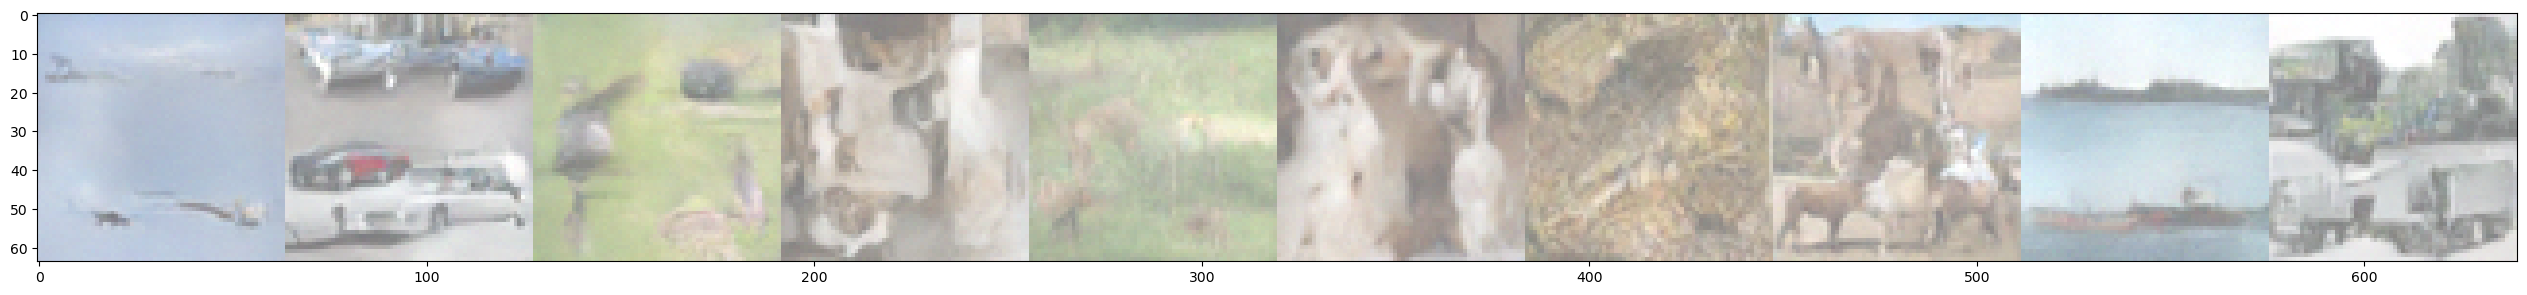

12:14:36 - INFO: Starting epoch 31:


12:16:04 - INFO: Starting epoch 32:


12:17:32 - INFO: Starting epoch 33:


12:18:59 - INFO: Starting epoch 34:


12:20:28 - INFO: Starting epoch 35:


12:21:55 - INFO: Starting epoch 36:


12:23:23 - INFO: Starting epoch 37:


12:24:51 - INFO: Starting epoch 38:


12:26:19 - INFO: Starting epoch 39:


12:27:47 - INFO: Starting epoch 40:


12:29:15 - INFO: Sampling 10 new images....


12:30:36 - INFO: Sampling 10 new images....


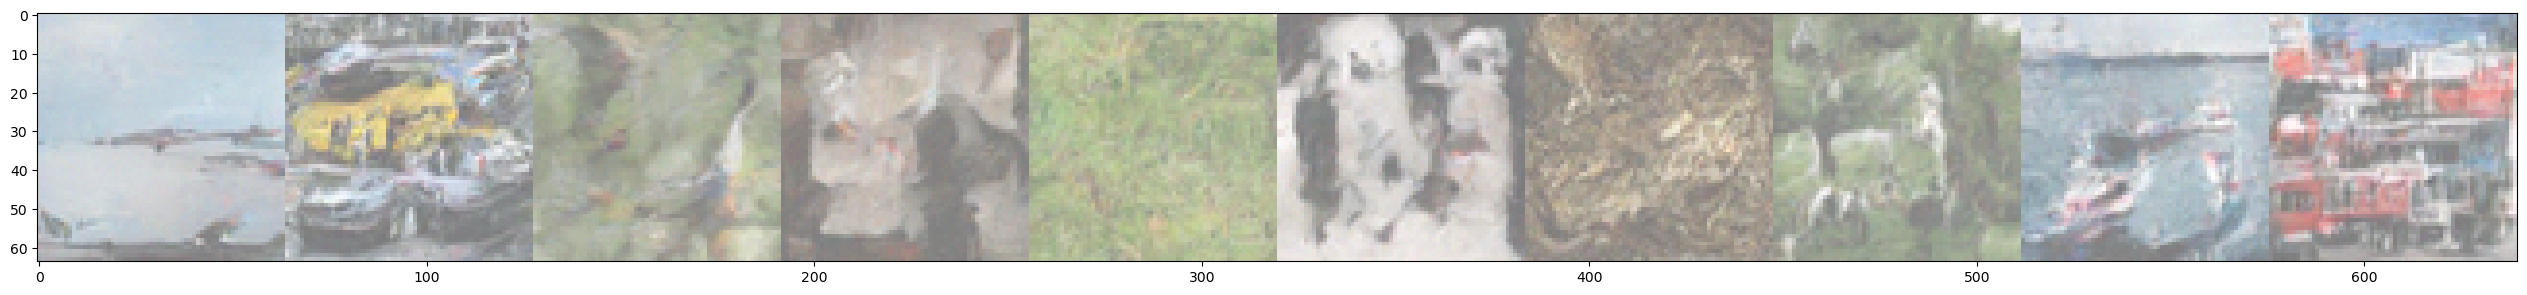

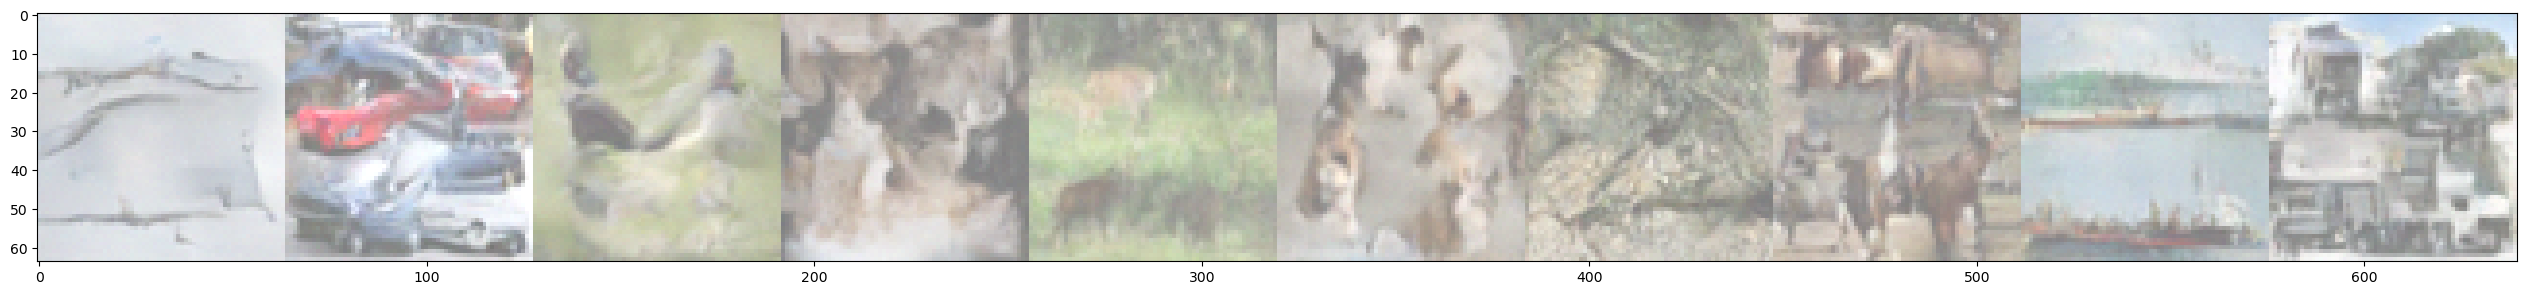

12:31:58 - INFO: Starting epoch 41:


12:33:26 - INFO: Starting epoch 42:


12:34:54 - INFO: Starting epoch 43:


12:36:22 - INFO: Starting epoch 44:


12:37:50 - INFO: Starting epoch 45:


12:39:18 - INFO: Starting epoch 46:


12:40:46 - INFO: Starting epoch 47:


12:42:14 - INFO: Starting epoch 48:


12:43:42 - INFO: Starting epoch 49:


12:45:10 - INFO: Starting epoch 50:


12:46:38 - INFO: Sampling 10 new images....


12:47:59 - INFO: Sampling 10 new images....


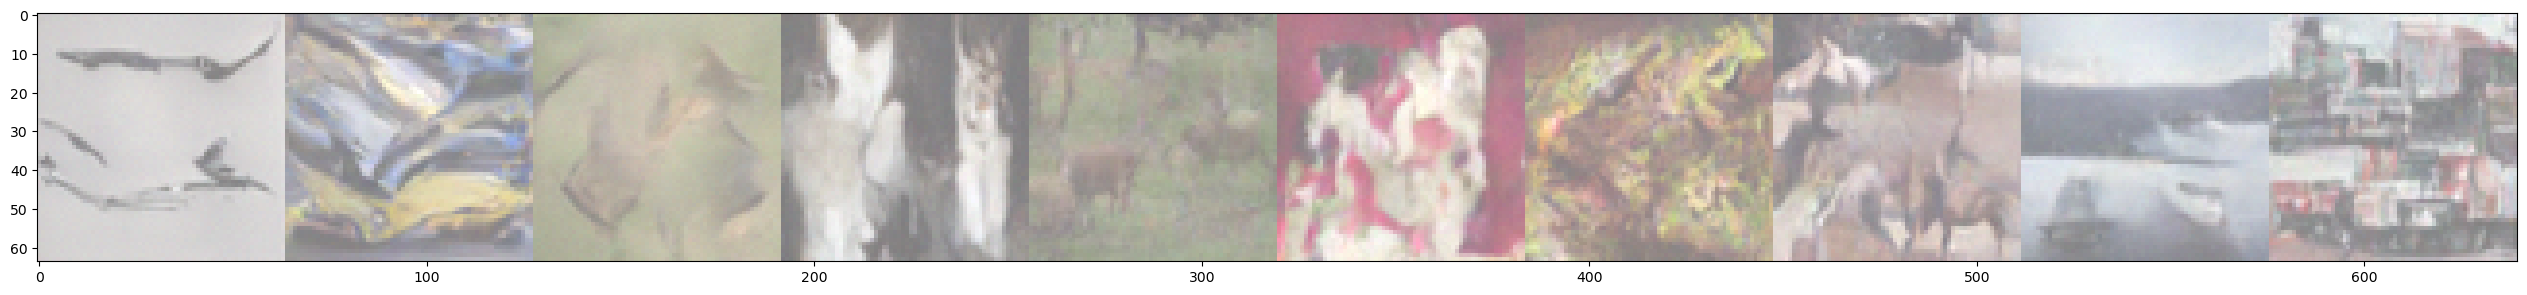

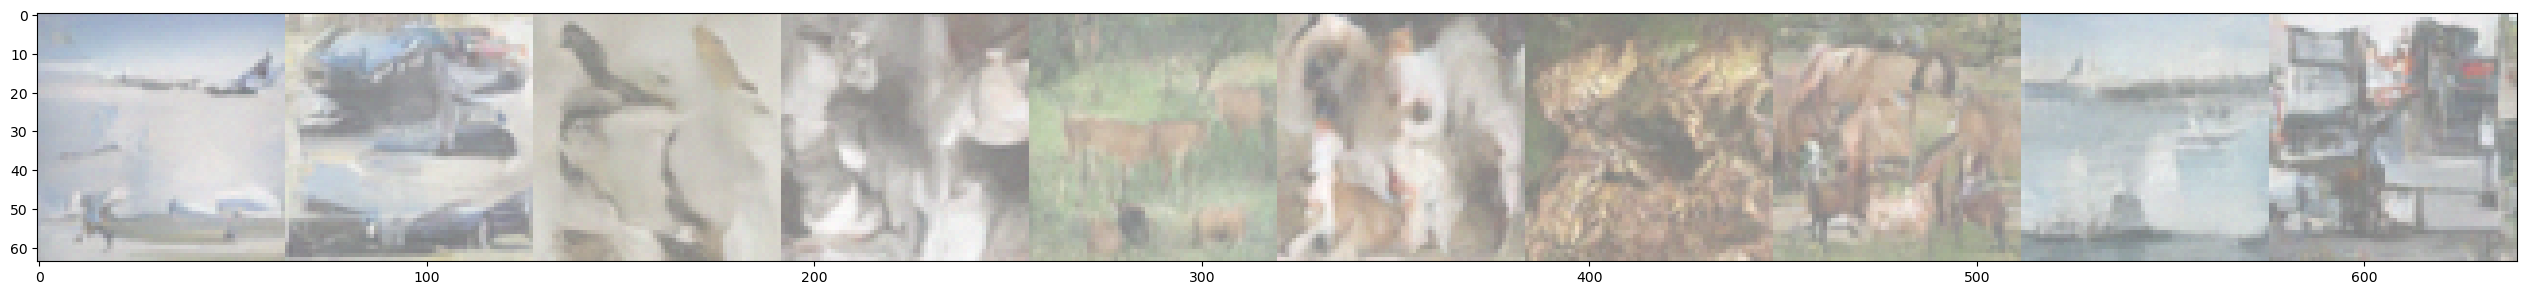

12:49:21 - INFO: Starting epoch 51:


12:50:49 - INFO: Starting epoch 52:


12:52:17 - INFO: Starting epoch 53:


12:53:45 - INFO: Starting epoch 54:


12:55:13 - INFO: Starting epoch 55:


12:56:41 - INFO: Starting epoch 56:


12:58:09 - INFO: Starting epoch 57:


12:59:37 - INFO: Starting epoch 58:


01:01:05 - INFO: Starting epoch 59:


01:02:33 - INFO: Starting epoch 60:


01:04:01 - INFO: Sampling 10 new images....


01:05:22 - INFO: Sampling 10 new images....


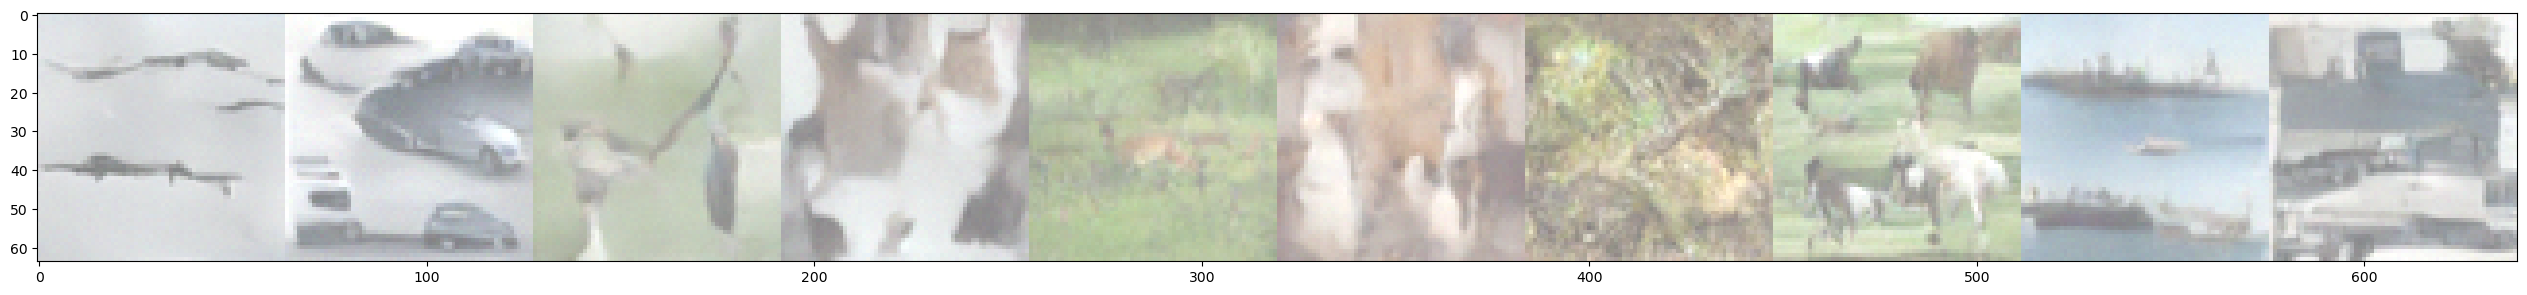

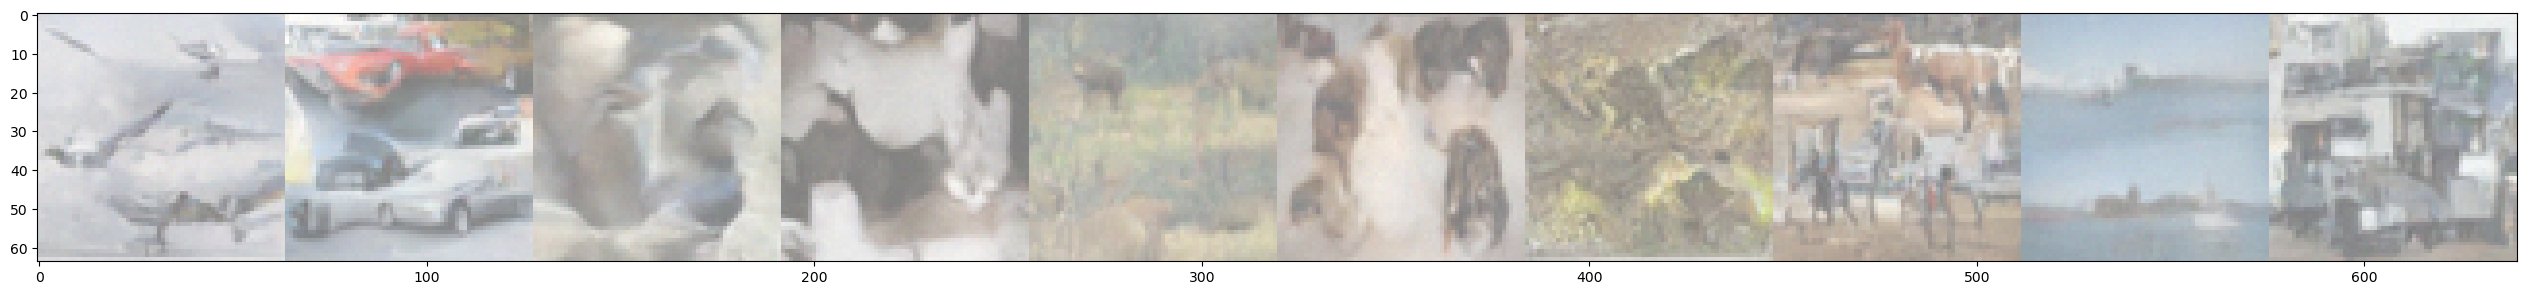

01:06:44 - INFO: Starting epoch 61:


01:08:12 - INFO: Starting epoch 62:


01:09:40 - INFO: Starting epoch 63:


01:11:09 - INFO: Starting epoch 64:


01:12:36 - INFO: Starting epoch 65:


01:14:04 - INFO: Starting epoch 66:


01:15:33 - INFO: Starting epoch 67:


01:17:01 - INFO: Starting epoch 68:


01:18:29 - INFO: Starting epoch 69:


01:19:56 - INFO: Starting epoch 70:


01:21:24 - INFO: Sampling 10 new images....


01:22:45 - INFO: Sampling 10 new images....


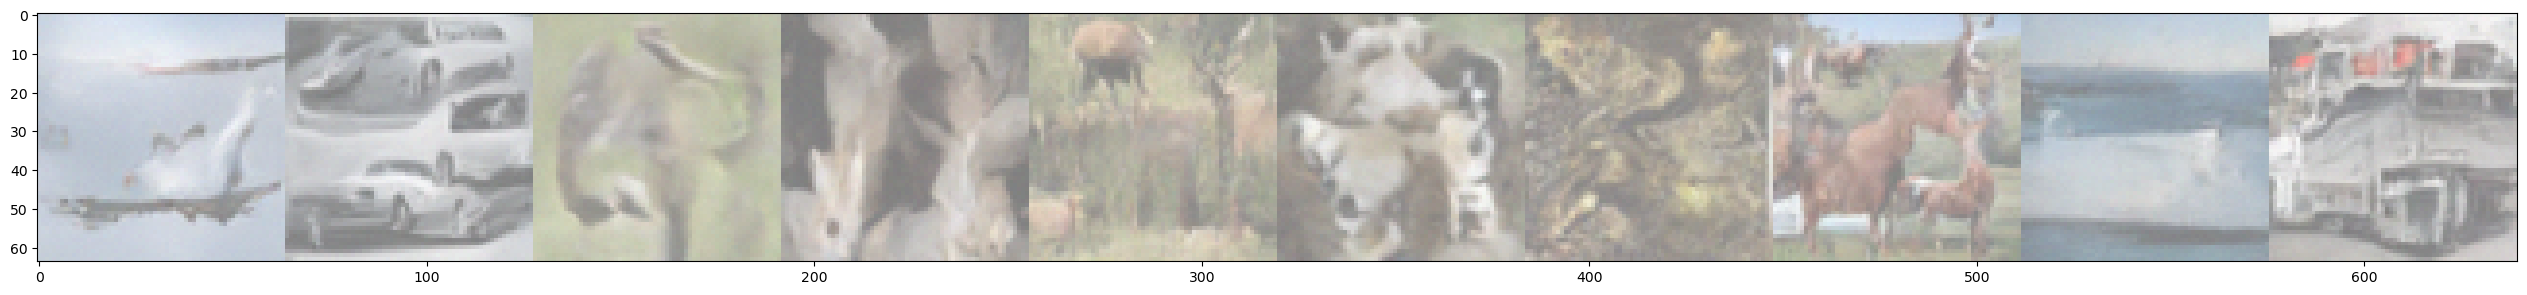

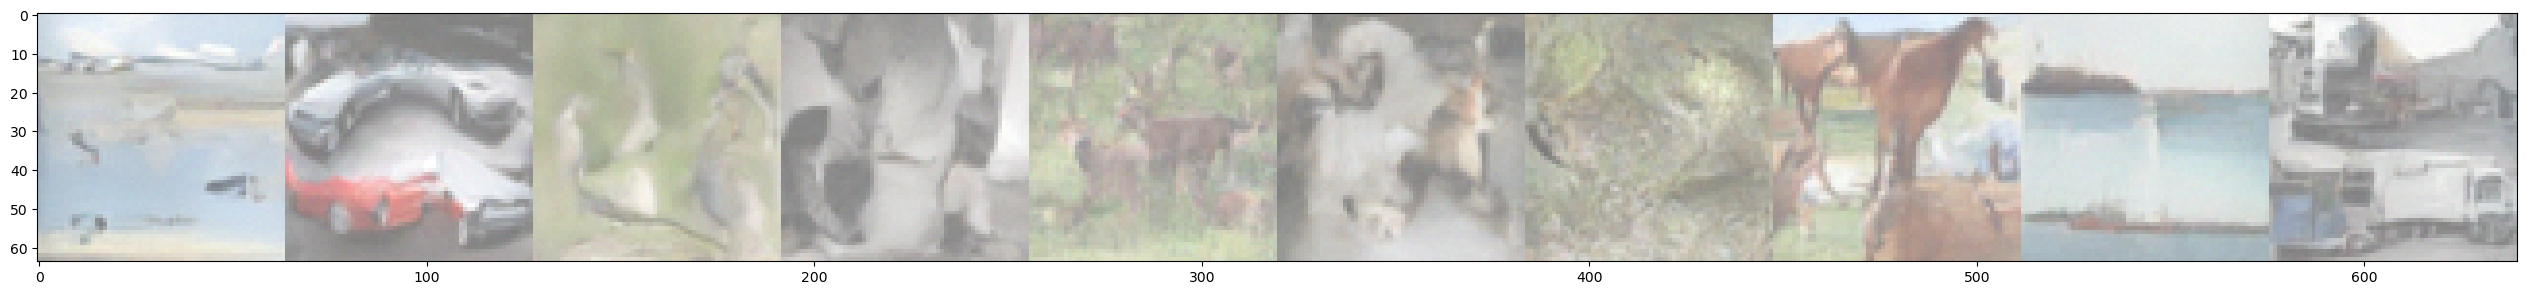

01:24:07 - INFO: Starting epoch 71:


01:25:36 - INFO: Starting epoch 72:


01:27:04 - INFO: Starting epoch 73:


01:28:32 - INFO: Starting epoch 74:


01:30:01 - INFO: Starting epoch 75:


01:31:29 - INFO: Starting epoch 76:


01:32:57 - INFO: Starting epoch 77:


01:34:25 - INFO: Starting epoch 78:


01:35:53 - INFO: Starting epoch 79:


01:37:21 - INFO: Starting epoch 80:


01:38:50 - INFO: Sampling 10 new images....


01:40:11 - INFO: Sampling 10 new images....


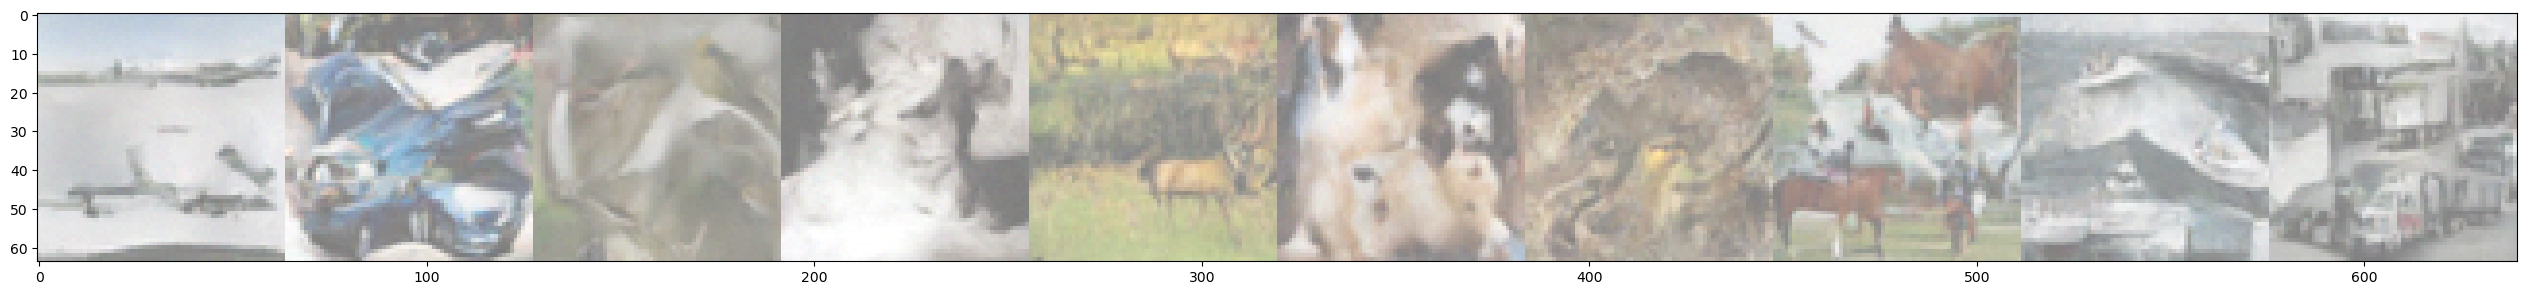

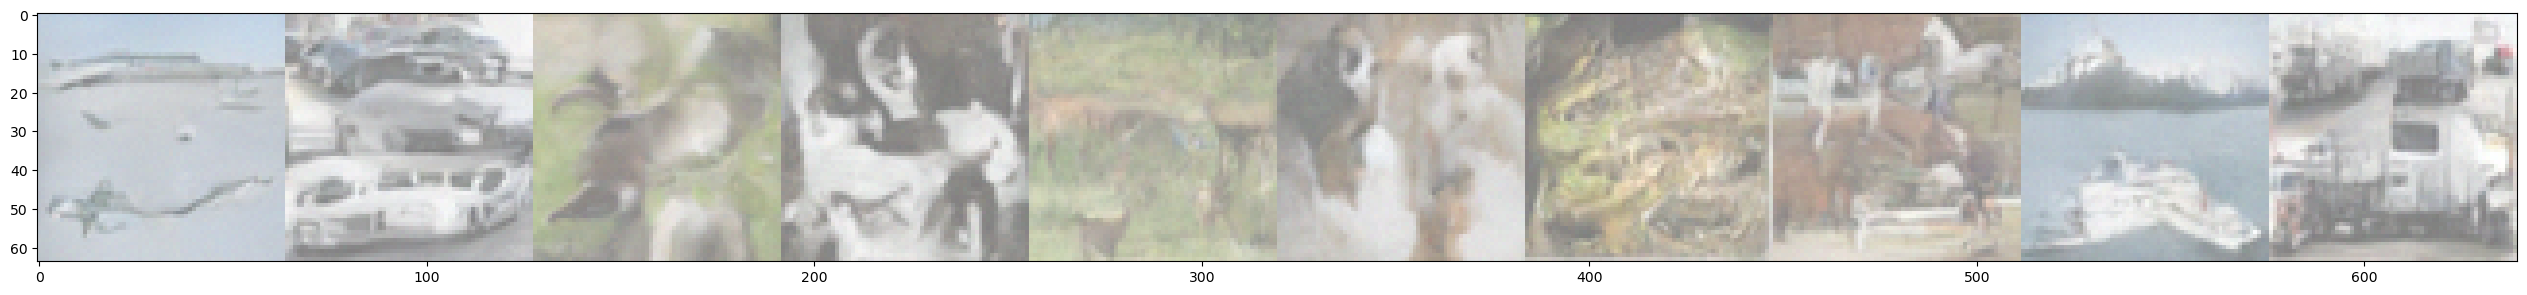

01:41:33 - INFO: Starting epoch 81:


01:43:01 - INFO: Starting epoch 82:


01:44:29 - INFO: Starting epoch 83:


01:45:57 - INFO: Starting epoch 84:


01:47:25 - INFO: Starting epoch 85:


01:48:52 - INFO: Starting epoch 86:


01:50:20 - INFO: Starting epoch 87:


01:51:48 - INFO: Starting epoch 88:


01:53:16 - INFO: Starting epoch 89:


01:54:44 - INFO: Starting epoch 90:


01:56:12 - INFO: Sampling 10 new images....


01:57:32 - INFO: Sampling 10 new images....


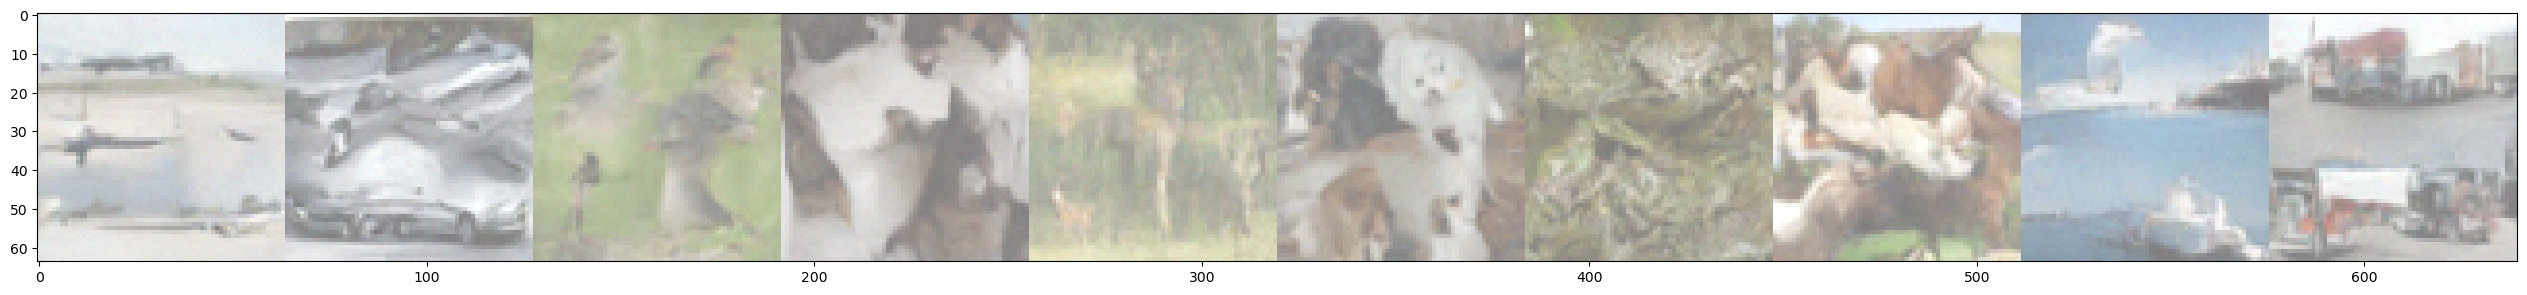

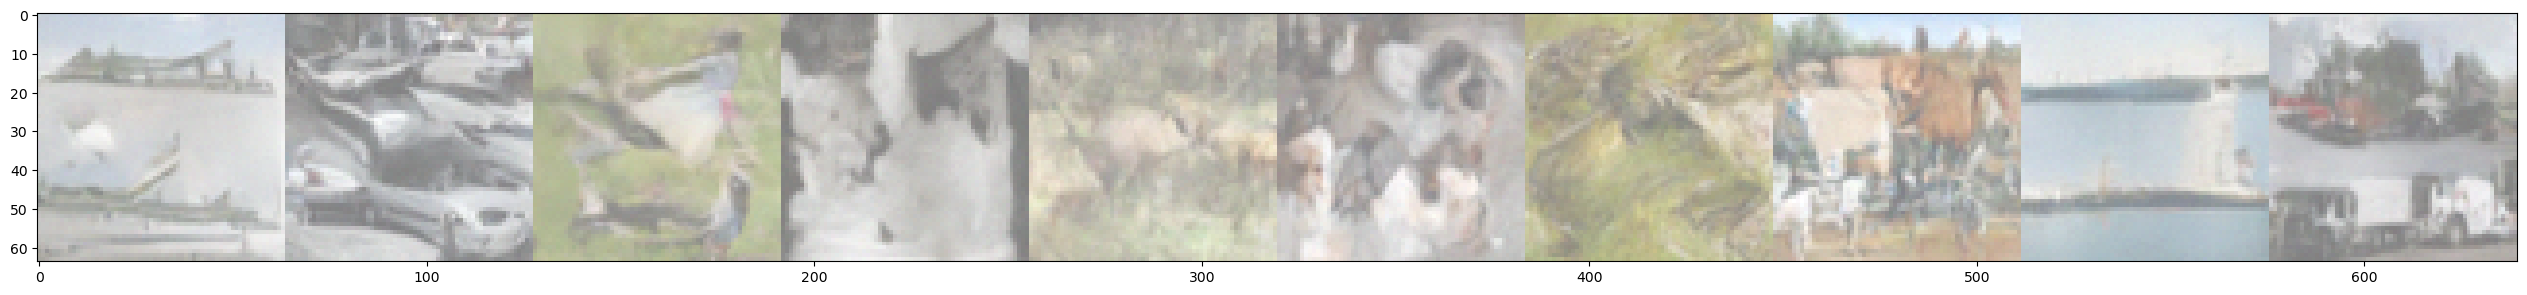

01:58:54 - INFO: Starting epoch 91:


02:00:22 - INFO: Starting epoch 92:


02:01:50 - INFO: Starting epoch 93:


02:03:18 - INFO: Starting epoch 94:


02:04:46 - INFO: Starting epoch 95:


02:06:14 - INFO: Starting epoch 96:


02:07:41 - INFO: Starting epoch 97:


02:09:10 - INFO: Starting epoch 98:


02:10:37 - INFO: Starting epoch 99:


Traceback (most recent call last):
  File "/tmp/ipykernel_4081/1360116313.py", line 12, in <module>
    diffuser.fit(config)
  File "/tmp/ipykernel_4081/130008081.py", line 216, in fit
    self.save_model(run_name=args.run_name, epoch=epoch)
  File "/tmp/ipykernel_4081/130008081.py", line 154, in save_model
    torch.save(self.model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
  File "/usr/lib/python3/dist-packages/torch/serialization.py", line 440, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/lib/python3/dist-packages/torch/serialization.py", line 315, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/lib/python3/dist-packages/torch/serialization.py", line 288, in __init__
    super().__init__(torch._C.PyTorchFileWriter(str(name)))
RuntimeError: Parent directory models/DDPM_conditional does not exist.


RuntimeError: Parent directory models/DDPM_conditional does not exist.

In [13]:
def load(self, model_cpkt_path, model_ckpt="ckpt.pt", ema_model_ckpt="ema_ckpt.pt"):
        self.model.load_state_dict(torch.load(os.path.join(model_cpkt_path, model_ckpt)))
        self.ema_model.load_state_dict(torch.load(os.path.join(model_cpkt_path, ema_model_ckpt)))




diffuser = Diffusion(config.noise_steps, img_size=config.img_size, num_classes=config.num_classes)
with wandb.init(project="train_sd", group="train", config=config):
    diffuser.prepare(config)
    diffuser.load('')
    diffuser.fit(config)

In [18]:
#labels = torch.arange(diffuser.num_classes).long().to(self.device)
dict = {
    "Airplane": 0,
    "Automobile": 1,
    "Bird": 2,
    "Cat": 3,
    "Deer": 4,
    "Dog": 5,
    "Frog": 6,
    "Horse": 7,
    "Ship": 8,
    "Truck": 9
}



02:59:05 - INFO: Sampling 10 new images....


03:00:25 - INFO: Sampling 10 new images....


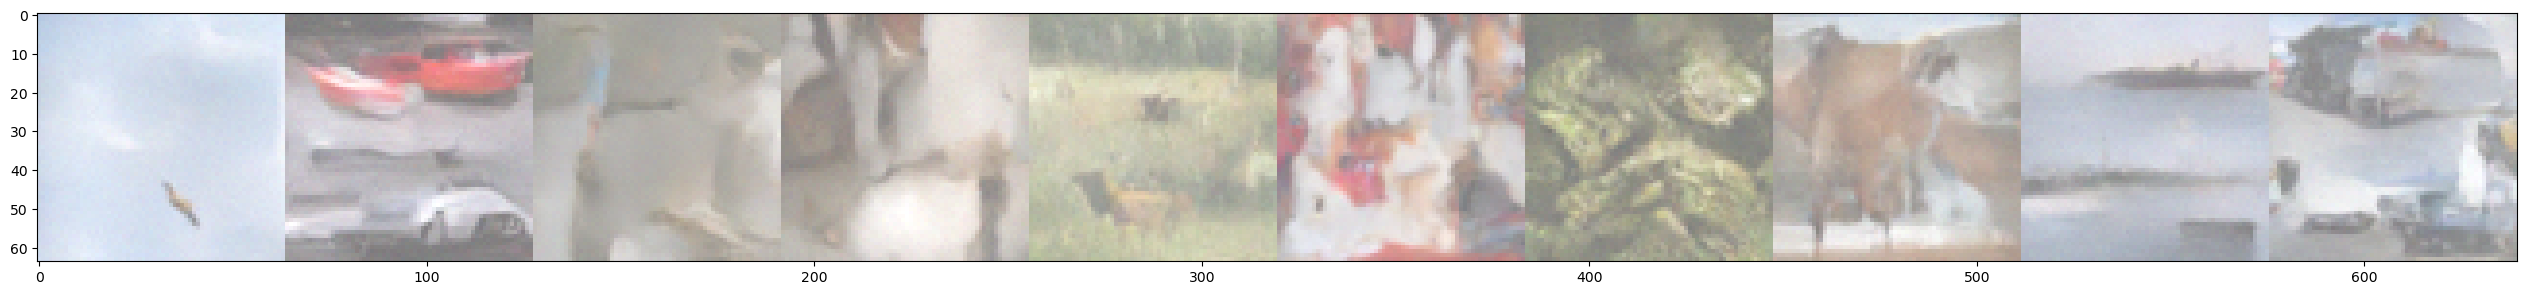

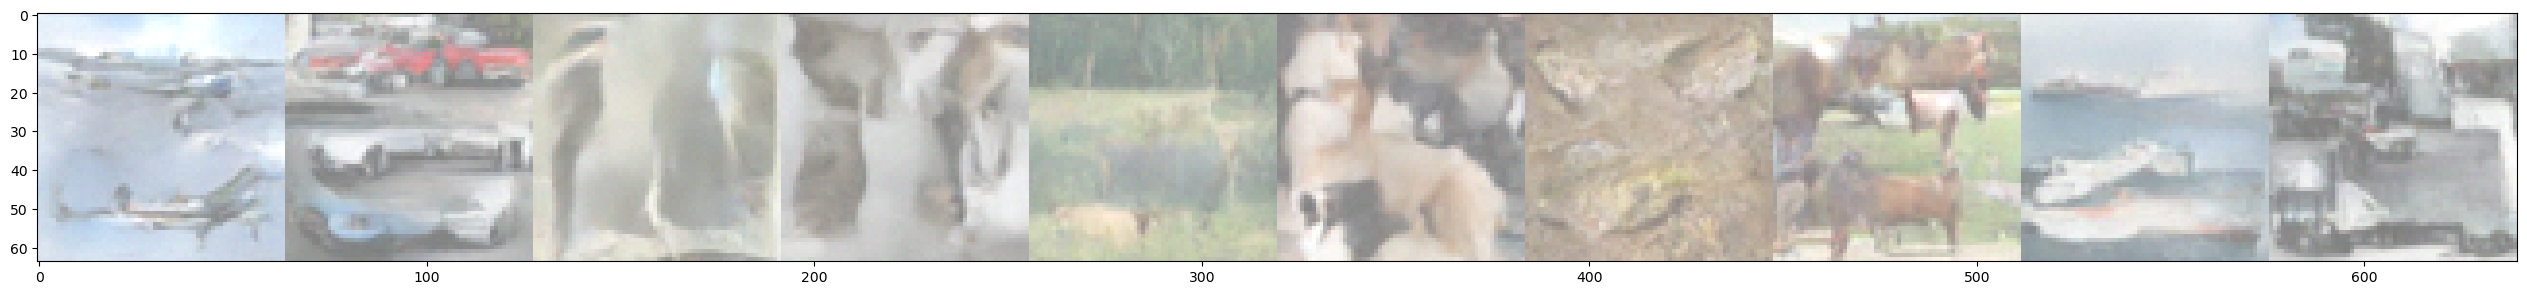

In [26]:
def generate_plot(name):
    values = [dict[n] for n in name]
    device = 'cuda'
    labels = torch.tensor(values, dtype=torch.long).to(device)
    sampled_images = diffuser.sample(use_ema=False, labels=labels)
    
    # EMA model sampling
    ema_sampled_images = diffuser.sample(use_ema=True, labels=labels)
    plot_images(sampled_images)  #to display on jupyter if available
    plot_images(ema_sampled_images)  #to display on jupyter if available

generate_plot(['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'])

## You can see results of generating images after 250 epochs of training. And images are good enough!